# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import datetime as dt
from datetime import datetime
from datetime import timedelta
from datetime import time

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

import feature_engine
from feature_engine.outliers import Winsorizer
from scipy.stats.mstats import winsorize

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Data Understanding

### Data Profiling

In [2]:
sheet_id = '1-rPoksqtegeqEkaFvGGMlpcFqfxx1gai-SicUizB4q4'
xls = pd.ExcelFile(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx')

df = pd.read_excel(xls, 'Dataset')

df.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1.0,10000.0
1,065321010200000076,2021-01-02 15:18:40,1.0,10000.0
2,065321010600000078,2021-01-06 15:28:17,1.0,10000.0
3,065321010600000078,2021-01-06 15:28:17,1.0,10000.0
4,065321010800000080,2021-01-08 09:39:05,1.0,10000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_no    457 non-null    object        
 1   order_time  457 non-null    datetime64[ns]
 2   qty         457 non-null    float64       
 3   amount      457 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 14.4+ KB


### Exploratory Data Analysis

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
qty,457.0,3.345733,6.558003,1.0,1.0,2.0,3.0,75.0
amount,457.0,33457.330416,65580.027079,10000.0,10000.0,20000.0,30000.0,750000.0


In [5]:
df_monthly = df.copy()
df_monthly.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1.0,10000.0
1,065321010200000076,2021-01-02 15:18:40,1.0,10000.0
2,065321010600000078,2021-01-06 15:28:17,1.0,10000.0
3,065321010600000078,2021-01-06 15:28:17,1.0,10000.0
4,065321010800000080,2021-01-08 09:39:05,1.0,10000.0


In [6]:
# mengubah format tanggal transaksi
df_monthly['order_time'] = pd.to_datetime(df_monthly['order_time'], format='%Y-%m-%d')

# mengelompokkan data berdasarkan bulan dan tahun
df_monthly = df_monthly.set_index('order_time').resample('M').sum().reset_index()

df_monthly

,order_time,qty,amount
0,2021-01-31,100.0,1000000.0
1,2021-02-28,140.0,1400000.0
2,2021-03-31,176.0,1760000.0
3,2021-04-30,79.0,790000.0
4,2021-05-31,103.0,1030000.0
5,2021-06-30,0.0,0.0
6,2021-07-31,50.0,500000.0
7,2021-08-31,230.0,2300000.0
8,2021-09-30,32.0,320000.0
9,2021-10-31,240.0,2400000.0


In [7]:
# membuat linechart menggunakan pyplot
plot_order = [
    go.Scatter(
        x = df_monthly['order_time'],
        y = df_monthly['qty'],
        mode = 'lines+markers'
    )
]

plot_layout = go.Layout(
#     xaxis = {'type': 'category', 'tickformat': '%Y/%m'},
    xaxis = {'tickformat': '%Y-%m-%d'},
    xaxis_title = 'Bulan',
    yaxis_title = 'Jumlah Penjualan',
    title = 'Tren Penjualan Energy Bar di Bulan Januari 2021 - Februari 2022'
)

fig = go.Figure(data=plot_order, layout=plot_layout)
fig.update_layout(plot_layout)
fig.show()

# Data Preparation

### Data Cleansing

In [8]:
# mengubah tipe data pada akolom qty dan price dari float ke int
df[['qty', 'amount']] = df[['qty', 'amount']].astype(float).astype(int)

df.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1,10000
1,065321010200000076,2021-01-02 15:18:40,1,10000
2,065321010600000078,2021-01-06 15:28:17,1,10000
3,065321010600000078,2021-01-06 15:28:17,1,10000
4,065321010800000080,2021-01-08 09:39:05,1,10000


In [9]:
dataset = df.copy()

### RFM Scoring

In [10]:
# timebound
print(dataset['order_time'].min())
print(dataset['order_time'].max())

2021-01-02 15:18:40
2022-02-24 16:08:23


In [11]:
now = dt.date(2022, 2, 24)
dataset['Date'] = pd.DatetimeIndex(dataset.order_time).date

In [12]:
# Recency
df_recency = dataset.groupby(['order_no'],as_index=False)['Date'].max()
df_recency.columns = ['order_no','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(now - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,order_no,Recency
0,065321010200000076,418
1,065321010600000078,414
2,065321010800000080,412
3,065321010800000082,412
4,065321010800000085,412


In [13]:
# Frequency & Monetary
df_fm = dataset.groupby('order_no').agg({'order_no':lambda x:len(x),
                                    'amount':lambda x:sum(x)})
df_fm.rename(columns = {'order_no' :'Frequency',
                        'amount':'Monetary'},inplace= True)
df_fm.head()

,Frequency,Monetary
order_no,,
065321010200000076,2,20000
065321010600000078,2,20000
065321010800000080,1,10000
065321010800000082,2,200000
065321010800000085,2,100000


In [14]:
RFM_Table = df_recency.merge(df_fm,left_on='order_no',right_on='order_no')
RFM_Table.head()

,order_no,Recency,Frequency,Monetary
0,065321010200000076,418,2,20000
1,065321010600000078,414,2,20000
2,065321010800000080,412,1,10000
3,065321010800000082,412,2,200000
4,065321010800000085,412,2,100000


In [15]:
RFM_Table_New = RFM_Table.drop(['order_no'], axis=1)

In [16]:
RFM_Table_New.head()

,Recency,Frequency,Monetary
0,418,2,20000
1,414,2,20000
2,412,1,10000
3,412,2,200000
4,412,2,100000


In [17]:
# RFM_Table.to_csv(r'C:\Users\ACER\SKRIPSI\data_rfm.csv')

### Deteksi Outlier

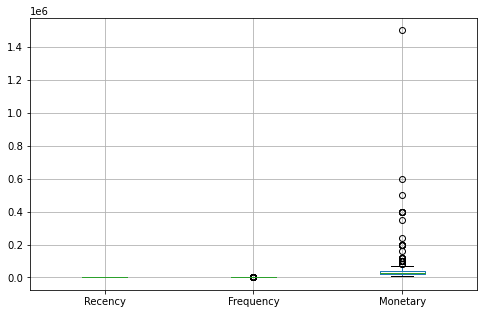

In [18]:
plt.figure(figsize=(8, 5))
RFM_Table_New.boxplot()
plt.show()

In [19]:
# hitung batas atas dan batas bawah untuk setiap variabel
q1 = RFM_Table_New.quantile(0.25)
q3 = RFM_Table_New.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [20]:
# winsorize data menggunakan batas atas dan batas bawah yang sudah dihitung
data_winsorized = pd.DataFrame()
for col in RFM_Table_New.columns:
    data_winsorized[col] = winsorize(RFM_Table_New[col], limits=0.05)
#     data_winsorized[col] = winsorize(RFM_Table_New[col], limits=(lower_bound[col], upper_bound[col]))

In [21]:
# tampilkan data asli dan data yang sudah di-winsorize
print('Data Asli:')
print(RFM_Table_New)

print('\nData Winsorized:')
print(data_winsorized)

Data Asli:
     Recency  Frequency  Monetary
0        418          2     20000
1        414          2     20000
2        412          1     10000
3        412          2    200000
4        412          2    100000
..       ...        ...       ...
255        2          2     30000
256        0          2     40000
257      300          2     20000
258      121          2    120000
259       86          1    500000

[260 rows x 3 columns]

Data Winsorized:
     Recency  Frequency  Monetary
0        406          2     20000
1        406          2     20000
2        406          1     10000
3        406          2    200000
4        406          2    100000
..       ...        ...       ...
255       17          2     30000
256       17          2     40000
257      300          2     20000
258      121          2    120000
259       86          1    200000

[260 rows x 3 columns]


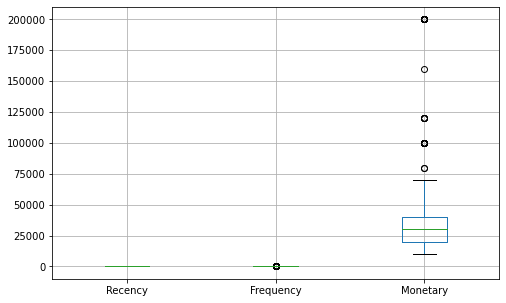

In [22]:
plt.figure(figsize=(8, 5))
data_winsorized.boxplot()
plt.show()

In [23]:
df_rfm = data_winsorized.copy()

In [24]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,260.000000,260.000000,260.000000
mean,221.011538,1.757692,46538.461538
std,124.076433,0.429306,48286.652727
min,17.000000,1.000000,10000.000000
25%,115.000000,2.000000,20000.000000
50%,201.000000,2.000000,30000.000000
75%,338.250000,2.000000,40000.000000
max,406.000000,2.000000,200000.000000


In [25]:
df_rfm.shape

(260, 3)

In [26]:
# df_rfm.to_csv(r'C:\Users\ACER\SKRIPSI\rfm_desc.csv')

### Transformasi Data

In [27]:
df_rfm_new = df_rfm.copy()
df_rfm_new.head()

,Recency,Frequency,Monetary
0,406,2,20000
1,406,2,20000
2,406,1,10000
3,406,2,200000
4,406,2,100000


In [28]:
df_rfm_new = np.log(df_rfm_new+1)

In [29]:
windsoriser = Winsorizer(tail='both',
                         fold=2,
                         variables=['Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_new)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [30]:
df_rfm_new = windsoriser.transform(df_rfm_new)

In [31]:
scaler = StandardScaler()
scaler.fit(df_rfm_new)
df_rfm_scaled = scaler.transform(df_rfm_new)

In [32]:
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=df_rfm.columns)
df_rfm_scaled.head()

,Recency,Frequency,Monetary
0,1.084883,0.565506,-0.574239
1,1.084883,0.565506,-0.574239
2,1.084883,-1.768328,-1.446730
3,1.084883,0.565506,2.079966
4,1.084883,0.565506,1.451719


In [33]:
df_rfm_scaled.shape

(260, 3)

# Modeling

In [34]:
X = np.asarray(df_rfm_scaled)

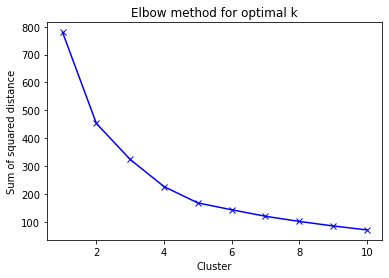

In [35]:
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')
plt.title('Elbow method for optimal k')
plt.show()

# Evaluation

In [36]:
model_kmeans_2 = KMeans(n_clusters = 2)
model_kmeans_2.fit(X)

KMeans(n_clusters=2)

In [37]:
model_kmeans_3 = KMeans(n_clusters = 3)
model_kmeans_3.fit(X)

KMeans(n_clusters=3)

In [38]:
model_kmeans_4 = KMeans(n_clusters = 4)
model_kmeans_4.fit(X)

KMeans(n_clusters=4)

In [39]:
model_kmeans_5 = KMeans(n_clusters = 5)
model_kmeans_5.fit(X)

KMeans(n_clusters=5)

In [40]:
model_kmeans_6 = KMeans(n_clusters = 6)
model_kmeans_6.fit(X)

KMeans(n_clusters=6)

In [41]:
model_kmeans_7 = KMeans(n_clusters = 7)
model_kmeans_7.fit(X)

KMeans(n_clusters=7)

In [42]:
model_kmeans_8 = KMeans(n_clusters = 8)
model_kmeans_8.fit(X)

KMeans()

In [43]:
model_kmeans_9 = KMeans(n_clusters = 9)
model_kmeans_9.fit(X)

KMeans(n_clusters=9)

In [44]:
model_kmeans_10 = KMeans(n_clusters = 10)
model_kmeans_10.fit(X)

KMeans(n_clusters=10)

<hr>

In [45]:
# davies_bouldin_score

In [46]:
print(davies_bouldin_score(X, model_kmeans_2.labels_))

0.9008003176221754


In [47]:
print(davies_bouldin_score(X, model_kmeans_3.labels_))

0.9830224217656102


In [48]:
print(davies_bouldin_score(X, model_kmeans_4.labels_))

0.7653054950920739


In [49]:
print(davies_bouldin_score(X, model_kmeans_5.labels_))

0.799508233577029


In [50]:
print(davies_bouldin_score(X, model_kmeans_6.labels_))

0.8477661243104743


In [51]:
print(davies_bouldin_score(X, model_kmeans_7.labels_))

0.8242245131053566


In [52]:
print(davies_bouldin_score(X, model_kmeans_8.labels_))

0.8542526595746796


In [53]:
print(davies_bouldin_score(X, model_kmeans_9.labels_))

0.7499783158048509


In [54]:
print(davies_bouldin_score(X, model_kmeans_10.labels_))

0.7001617038009796


# Deployment

In [55]:
# labeling
df_clustered = pd.DataFrame(RFM_Table)
df_clustered['cluster'] = pd.DataFrame(model_kmeans_4.labels_)
df_clustered = df_clustered.sort_values('cluster')
data_clustered = np.asarray(df_clustered)

data_clustered

array([['06C922010400000590', 51, 2, 20000, 0],
       ['06C922010400000588', 51, 2, 20000, 0],
       ['06C922010400000587', 51, 2, 20000, 0],
       ...,
       ['E39421030300000125', 358, 2, 400000, 3],
       ['E39421091400000469', 163, 2, 80000, 3],
       ['OL22010500000078', 86, 1, 500000, 3]], dtype=object)

In [56]:
cluster_labels = model_kmeans_4.labels_

In [57]:
rfm_labels_4 = RFM_Table.assign(cluster = cluster_labels)

rfm_labels_4.head()

,order_no,Recency,Frequency,Monetary,cluster
0,065321010200000076,418,2,20000,2
1,065321010600000078,414,2,20000,2
2,065321010800000080,412,1,10000,1
3,065321010800000082,412,2,200000,3
4,065321010800000085,412,2,100000,3


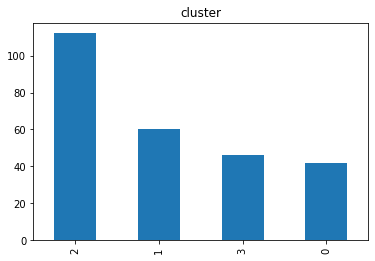

In [58]:
rfm_labels_4['cluster'].value_counts().plot(kind='bar');
plt.title('cluster');

In [59]:
df_clustered

,order_no,Recency,Frequency,Monetary,cluster
129,06C922010400000590,51,2,20000,0
127,06C922010400000588,51,2,20000,0
126,06C922010400000587,51,2,20000,0
125,06C921122800000555,58,2,30000,0
124,06C921122400000546,62,2,40000,0
...,...,...,...,...,...
97,06C921110900000381,107,2,70000,3
100,06C921111600000407,100,2,240000,3
170,E39421030300000125,358,2,400000,3
232,E39421091400000469,163,2,80000,3


In [60]:
# df_clustered.to_csv(r'C:\Users\ACER\SKRIPSI\data_cluster.csv')

In [61]:
cluster_0 = df_clustered.loc[df_clustered['cluster'] == 0]

cluster_0.head()

,order_no,Recency,Frequency,Monetary,cluster
129,06C922010400000590,51,2,20000,0
127,06C922010400000588,51,2,20000,0
126,06C922010400000587,51,2,20000,0
125,06C921122800000555,58,2,30000,0
124,06C921122400000546,62,2,40000,0


In [62]:
cluster_1 = df_clustered.loc[df_clustered['cluster'] == 1]

cluster_1.head()

,order_no,Recency,Frequency,Monetary,cluster
75,06C921101300000308,134,1,10000,1
148,E39421020900000069,380,1,10000,1
189,E39421040100000199,329,1,10000,1
93,06C921110400000369,112,1,10000,1
188,E39421033100000196,330,1,10000,1


In [63]:
cluster_2 = df_clustered.loc[df_clustered['cluster'] == 2]

cluster_2.head()

,order_no,Recency,Frequency,Monetary,cluster
257,OL21050300000018,300,2,20000,2
152,E39421021500000082,374,2,40000,2
153,E39421021500000083,374,2,20000,2
154,E39421021500000084,374,2,20000,2
167,E39421022300000112,366,2,20000,2


In [64]:
cluster_3 = df_clustered.loc[df_clustered['cluster'] == 3]

cluster_3.head()

,order_no,Recency,Frequency,Monetary,cluster
161,E39421022000000102,369,2,120000,3
131,06C922010600000592,49,2,400000,3
22,06C921070900000099,230,2,100000,3
258,OL21120600000072,121,2,120000,3
21,06C921070900000095,230,2,100000,3


In [65]:
cluster_0.shape

(42, 5)

In [66]:
cluster_1.shape

(60, 5)

In [67]:
cluster_2.shape

(112, 5)

In [68]:
cluster_3.shape

(46, 5)

In [69]:
cluster_0.describe()

,Recency,Frequency,Monetary,cluster
count,42.000000,42.000000,42.000000,42.0
mean,57.833333,1.976190,36428.571429,0.0
std,38.182435,0.154303,20579.581234,0.0
min,0.000000,1.000000,20000.000000,0.0
25%,14.750000,2.000000,20000.000000,0.0
50%,62.500000,2.000000,35000.000000,0.0
75%,90.000000,2.000000,40000.000000,0.0
max,119.000000,2.000000,100000.000000,0.0


In [70]:
cluster_1.describe()

,Recency,Frequency,Monetary,cluster
count,60.000000,60.0,60.000000,60.0
mean,222.500000,1.0,16500.000000,1.0
std,134.893618,0.0,10865.120683,0.0
min,2.000000,1.0,10000.000000,1.0
25%,112.000000,1.0,10000.000000,1.0
50%,190.000000,1.0,10000.000000,1.0
75%,362.000000,1.0,20000.000000,1.0
max,412.000000,1.0,50000.000000,1.0


In [71]:
cluster_2.describe()

,Recency,Frequency,Monetary,cluster
count,112.000000,112.0,112.000000,112.0
mean,268.982143,2.0,29732.142857,2.0
std,89.592871,0.0,10777.004333,0.0
min,126.000000,2.0,20000.000000,2.0
25%,190.000000,2.0,20000.000000,2.0
50%,289.000000,2.0,20000.000000,2.0
75%,343.500000,2.0,40000.000000,2.0
max,418.000000,2.0,50000.000000,2.0


In [72]:
cluster_3.describe()

,Recency,Frequency,Monetary,cluster
count,46.000000,46.000000,4.600000e+01,46.0
mean,249.804348,1.956522,2.052174e+05,3.0
std,117.660268,0.206185,2.338826e+05,0.0
min,49.000000,1.000000,7.000000e+04,3.0
25%,135.500000,2.000000,1.000000e+05,3.0
50%,271.000000,2.000000,1.000000e+05,3.0
75%,350.500000,2.000000,2.000000e+05,3.0
max,412.000000,2.000000,1.500000e+06,3.0
